# Data Science Incubator Project Idea

This notebook contains results from the simulations as described by Lorch et al., 2020 [paper](https://arxiv.org/abs/2004.07641) and with alternations that simulate public gatherings, different essential workers, and a few more adjustments.

The notebook is organized as follows:

* In Section 1, we define all the simulation parameters.
* In Section 2, we plot the results from Wave 2 assuming Contact Tracing at SF rates and Wave 2 assuming no CT.


---

## 1. Define the experiment parameters

#### Import libs

In [1]:
import numpy as np
import pickle, math
import pandas as pd
import multiprocessing

In [2]:
%load_ext autoreload
%autoreload 2
from lib.mobilitysim import MobilitySimulator
from lib.parallel import launch_parallel_simulations
from lib.distributions import CovidDistributions
from lib.data import collect_data_from_df
from lib.measures import (MeasureList, Interval,
                          BetaMultiplierMeasureByType,
                          SocialDistancingForAllMeasure, 
                          SocialDistancingForPositiveMeasure,
                          SocialDistancingForPositiveMeasureHousehold)
from lib.inference import gen_initial_seeds, extract_seeds_from_summary
from lib.plot import Plotter
from lib.runutils import *
import matplotlib.pyplot as plt
%matplotlib inline

# converting days to hours
TO_HOURS = 24.0

#### Set the random seed for reproducibility

In [3]:
# Choose random seed
c = 0
# Set it
np.random.seed(c)
# Define prefix string used to save plots
runstr = f'run{c}_'

#### Set the number of roll-outs to simulate

In [4]:
random_repeats = 40 # Set to at least 40 to obtain stable results

#### Define the number of parallel workers used for simulations 

In [5]:
num_workers = multiprocessing.cpu_count() - 1

#### Set the time to simulate

In [6]:
start_date = '2020-05-26'
end_date = '2020-08-26'
sim_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
max_time = TO_HOURS * sim_days # in hours

#### Define population/mobility parameters

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

Check out `lib/mobility/` and `lib/settings/` for all pre-generated towns in Germany and Switzerland. 

In [7]:
from lib.settings.town_settings_tubingen import *
mob_settings = 'lib/mobility/San_Francisco_settings_100_type0-1-2-3-4_20pct_social_graph_homesite_new_mob.pk'  
area = 'SF'
country = 'US'

# See town-generator.ipynb for an example on how to create the settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)
downsample = mob.downsample

#### Load the case data

Adjust the number of cases to the down-scaling of the population

[2496. 2530. 2553. 2583. 2605. 2630. 2668. 2713. 2740. 2778. 2807. 2823.
 2841. 2876. 2909. 2928. 2951. 2978. 2998. 3013. 3048. 3096. 3147. 3192.
 3235. 3276. 3308. 3413. 3492. 3553. 3620. 3689. 3740. 3777. 3849. 3947.
 4025. 4128. 4208. 4235. 4285. 4371. 4471. 4582. 4689. 4819. 4886. 4952.
 5091. 5251. 5405. 5551. 5706. 5786. 5860. 6005. 6133. 6259. 6381. 6501.
 6580. 6639. 6731. 6827. 6964. 7090. 7205. 7271. 7316. 7420. 7503. 7635.
 7735. 7865. 7926. 7986. 8088. 8194. 8328. 8431. 8539. 8604. 8642. 8723.
 8805. 8901. 8986. 9064. 9107. 9147. 9239. 9318. 9408.]


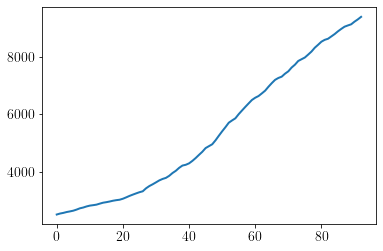

In [8]:
new_cases_ = collect_data_from_df(country=country, area=area, datatype='new',
    start_date_string=start_date,  end_date_string=end_date)
# new_cases = new_cases_
new_cases = np.ceil(
        (new_cases_ * mob.num_people_unscaled) /
        (1 * mob.region_population))
print((new_cases.sum(1)))
plt.plot(new_cases.sum(1));

## 2. Plot the results

Load the summary holding the results of the experiment to plot.

In [11]:
summary_CT = load_summary('wave2opt_wave2_CT.pk')
summary_noCT = load_summary('wave2opt_wave2.pk')

Calculate the average number of lives saved due to manual contact tracing. Compare simulation with contact tracing and without contact tracing. 

In [12]:
print(num_infected(summary_CT['basic'][0])*downsample)
print(num_infected(summary_noCT['basic'][0])*downsample)
average_exposure_prevented = (num_infected(summary_CT['basic'][0])-num_infected(summary_noCT['basic'][0]))*downsample
print(average_exposure_prevented)

6892.500000000001
6717.5
175.00000000000142


In [13]:
from lib.runutils import num_essential_infected
print(num_essential_infected(summary_CT['basic'][0])*downsample)
print(num_essential_infected(summary_noCT['basic'][0])*downsample)
average_essential_exposure_prevented = (num_essential_infected(summary_CT['basic'][0])-num_essential_infected(summary_noCT['basic'][0]))*downsample
print(average_essential_exposure_prevented)

1122.5
1095.0
27.500000000000036


Example plot (a)

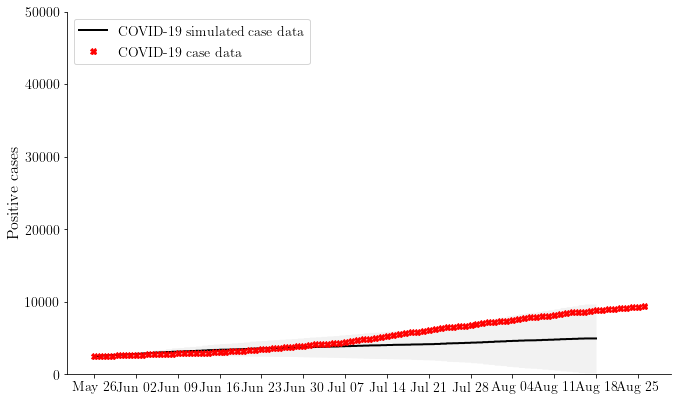

In [14]:
lockdown_at_day = 17
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_CT['basic'][0], new_cases.sum(axis=1), 
    title='Example', 
    filename=runstr + 'ex_00',
    figsize=(10, 6),
    start_date=start_date,
    errorevery=1, acc=1000, 
    ymax=50000,
    downsample=downsample)


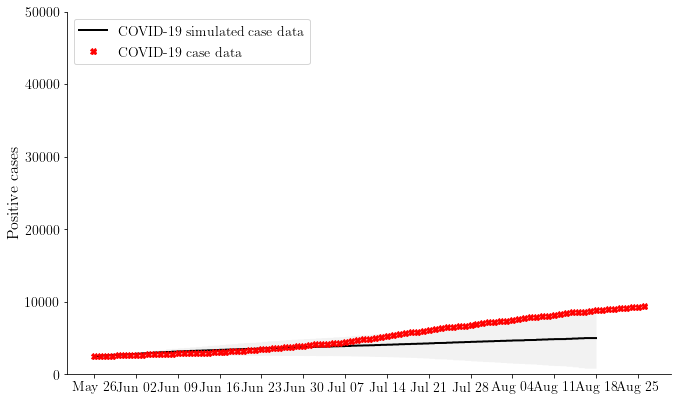

In [15]:
lockdown_at_day = 17
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_noCT['basic'][0], new_cases.sum(axis=1), 
    title='Example', 
    filename=runstr + 'ex_00',
    figsize=(10, 6),
    start_date=start_date,
    errorevery=1, acc=1000, 
#     lockdown_at=lockdown_at_day,
    ymax=50000,
    downsample=downsample)